# EasyOCR

In [56]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 21.7 MB/s eta 0:00:00


In [69]:
import easyocr

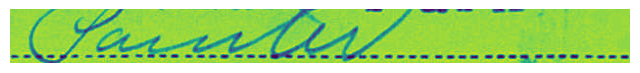

In [115]:
# Check example
image_path = '/content/images/007625955_007625955_00651_22.png'
plot_image(image_path)

In [116]:
# Run OCR
reader = easyocr.Reader(['en'])
results = reader.readtext(image_path)
ocr_results = [(text, conf) for (_, text, conf) in results]
ocr_results

[]

# Zero-shot OCR
This uses a pre-trained model to transcribe the image. Model used from HuggingFace is <code>microsoft/trocr-base-handwritten</code>

https://huggingface.co/docs/transformers/v4.46.3/en/model_doc/trocr#transformers.TrOCRProcessor

In [117]:
# Import libraries
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import os
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [93]:
#Functions definitions
def zero_shot_recognition(image_path, model, processor):
    """
    Get transcription of the image and score.

    Args:
        image_path (str): Path to the image.
    Returns:
        tuple: Transcribed text and confidence score.
    """
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values

    outputs = model.generate(
        pixel_values,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=2
    )

    generated_text = processor.batch_decode(outputs.sequences, skip_special_tokens=True)[0]

    # Compute scores
    scores = torch.stack(outputs.scores)
    probabilities = F.softmax(scores, dim=-1)
    token_probs = probabilities.max(dim=-1).values
    avg_confidence = token_probs.mean().item()

    return image_path, generated_text, avg_confidence


def plot_image(image_path):
    """
    Plot the image.

    Args:
        image_path (str): Path to the image.
    """
    try:
        image = Image.open(image_path)

        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error showing image: {e}")

In [94]:
# Load pre-trained model and processor
model_name = "microsoft/trocr-base-handwritten"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForVision2Seq.from_pretrained(model_name)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

In [119]:
# Check prediction for given image
zero_shot_recognition(image_path, model, processor)

('/content/images/007625955_007625955_00651_22.png',
 'CLASSED',
 0.1420915275812149)

In [120]:
# Load all the images
images = [f for f in os.listdir('./images') if f.endswith(('.png'))]
df = pd.DataFrame(images, columns=["snippet_name"])

In [121]:
# Inference in all rows
df['model_output'] = df.apply(lambda x: zero_shot_recognition(f'./images/{x["snippet_name"]}', model, processor), axis=1)

In [122]:
# Build final output
df['label'] = df['model_output'].apply(lambda x: x[1])
df['confidence_score'] = df['model_output'].apply(lambda x: x[2])
df.drop(columns=['model_output'], inplace=True)

In [123]:
df.to_csv('predictions.csv')

In [124]:
df

,snippet_name,label,confidence_score
0,007646650_007646650_03109_22.png,1962,0.097105
1,007646650_007646650_04650_22.png,twatt,0.244435
2,007626266_007626266_02067_22.png,1944,0.053975
3,007625976_007625976_02146_22.png,a b,0.125759
4,007646537_007646537_00640_22.png,middle seat,0.153082
...,...,...,...
95,007643908_007643908_01593_22.png,# the,0.146849
96,007644572_007644572_01456_22.png,a b,0.257285
97,007625911_007625911_00105_22.png,a member,0.090713
98,007646242_007646242_02724_22.png,Colorado States,0.142029
